# Embeddings

In [1]:
# ! pip install -r requirements.in
# !pip install skip_kernel_extension

In [2]:
!pip install datasets
!pip install sentence_transformers
!pip install utils
!pip install gensim nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=10aa7a8f66a06d467614c5923f3abda305e190d9475533125c7402cf2d80cd00
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [3]:
import os
import numpy as np
import warnings
import itertools

from sklearn.metrics import accuracy_score

import os
import pickle
import numpy as np
import pandas as pd
import warnings
import itertools
import csv
import random
random.seed(0)  # standardized default seed

import torch
from datasets import Dataset, load_dataset
import torch
import torch.nn.functional as F

from utils import *
# from utils.feed_forward import FeedForward
# from utils.cls import extract_cls_embeddings
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [4]:
# Set Device ##########################################################
device_name = "cpu"  # default device is CPU
if torch.cuda.is_available():
    device_name = "cuda"  # CUDA for NVIDIA GPU
elif torch.backends.mps.is_available():
    device_name = torch.device("mps")  # Metal Performance Shaders for Apple M-series GPU
device = torch.device(device_name)
print(device_name)
#######################################################################

cpu


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Change these:

In [36]:
# choose cached or not
cached = True

# choose model
## 'MPNetBase'
## 'DistilRoBERTaBase'
## 'MPNetST'
## 'DistilRoBERTaST'
## 'GloVe100'
model_name = 'DistilRoBERTaBase'

emb_size = 768
if model_name == 'GloVe100':
  emb_size = 100

# choose task
## 'cola'
## 'sst2'
## 'mrpc'
## 'stsb'
## 'qnli'
## 'rte'
## 'wnli'
task = 'cola'

two_sentence = True
if task == 'cola' or task == 'sst2':
  two_sentence = False

# choose type
## 'cls'
## 'mean_pooling'
## 'st'
## 'cbow'
emb_type = 'cls'

# choose the number of isomap and t-sne components
## usually 2 or 3
n_isomap_components = 2
n_tsne_components = 2

## Set model

In [37]:
if model_name == 'MPNetBase':
  from transformers import MPNetTokenizer, MPNetModel
  tokenizer = MPNetTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
  model = MPNetModel.from_pretrained("microsoft/mpnet-base").to(device)

In [38]:
if model_name == 'DistilRoBERTaBase':
  from transformers import RobertaTokenizer, RobertaModel
  tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')
  model = RobertaModel.from_pretrained('distilroberta-base').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [39]:
if model_name == 'MPNetST':
  from sentence_transformers import SentenceTransformer
  model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device)

In [40]:
if model_name == 'DistilRoBERTaST':
  from sentence_transformers import SentenceTransformer
  model = SentenceTransformer('sentence-transformers/all-distilroberta-v1').to(device)

In [41]:
if model_name == 'GloVe100':
  import gensim.downloader as api
  model = api.load('glove-wiki-gigaword-100')  # or another model

## Load data

In [42]:
data = load_dataset("glue", task)
data

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

## Run if embeddings have already been cached

In [43]:
# assumes embeddings are saved in .npy files

if cached:
  # Specify the path to your embeddings file in Google Drive
  # Update the path below according to where your file is stored in Google Drive
  file_path = f'/content/drive/My Drive/projectx_pain/embeddings/{emb_type}/{task}/X_train_{model_name}.npy'
  X_train_cls = np.load(file_path)

  file_path = f'/content/drive/My Drive/projectx_pain/embeddings/{emb_type}/{task}/X_test_{model_name}.npy'
  X_test_cls = np.load(file_path)

  file_path = f'/content/drive/My Drive/projectx_pain/embeddings/{emb_type}/{task}/X_val_{model_name}.npy'
  X_val_cls = np.load(file_path)

  # set to u-v embedding
  if two_sentence:
    X_train_cls = np.abs(X_train_cls[:, 0:emb_size] - X_train_cls[:, emb_size:])
    X_test_cls = np.abs(X_test_cls[:, 0:emb_size] - X_test_cls[:, emb_size:])
    X_val_cls = np.abs(X_val_cls[:, 0:emb_size] - X_val_cls[:, emb_size:])

  # Check the shape of the loaded embeddings
  print("X_train_cls shape:", X_train_cls.shape)
  print("X_test_cls shape:", X_test_cls.shape)
  print("X_val_cls shape:", X_val_cls.shape)

X_train_cls shape: (8551, 768)
X_test_cls shape: (1063, 768)
X_val_cls shape: (1043, 768)


In [44]:
if cached:
  Y_train = data["train"]["label"]
  Y_val = data["validation"]["label"]
  Y_test = data["test"]["label"]

In [45]:
if cached:
  # truncate to just the first 5000 examples so that it's easier to run

  print(np.min([5000, np.size(X_train_cls, 0)]))

  print(X_train_cls.shape)
  X_train_cls = X_train_cls[0:np.min([5000, np.size(X_train_cls, 0)]), :]
  Y_train = Y_train[0:np.min([5000, np.size(Y_train)])]

  print("X_train_cls shape:", X_train_cls.shape)
  print("Y_train len:", len(Y_train))

5000
(8551, 768)
X_train_cls shape: (5000, 768)
Y_train len: 5000


## Load/Generate cls embeddings
(note there is no generation of mean pooling; don't use this notebook if you don't already have cached mean pooled embeddings)

### Run for single sentence tasks; skip for double sentence tasks

In [46]:
if not cached and emb_type == 'cls' and not two_sentence:
  ### ONLY FOR SINGLE SENTENCES

  X_train = data["train"]["sentence"]
  X_val = data["validation"]["sentence"]
  X_test = data["test"]["sentence"]

  Y_train = data["train"]["label"]
  Y_val = data["validation"]["label"]
  Y_test = data["test"]["label"]

  # # only select 10% of each for the purpose of embeddings
  # proportion = 0.10

  # tr_len = len(X_train)
  # tr_indices = np.random.choice(tr_len, int(tr_len * proportion), replace=False)
  # X_train = (np.array(X_train)[tr_indices]).tolist()
  # Y_train = (np.array(Y_train)[tr_indices]).tolist()

  # v_len = len(X_val)
  # v_indices = np.random.choice(v_len, int(v_len * proportion), replace=False)
  # X_val = (np.array(X_val)[v_indices]).tolist()
  # Y_val = (np.array(Y_val)[v_indices]).tolist()

  # te_len = len(X_test)
  # te_indices = np.random.choice(te_len, int(te_len * proportion), replace=False)
  # X_test = (np.array(X_test)[te_indices]).tolist()
  # Y_test = (np.array(Y_test)[te_indices]).tolist()

In [47]:
if not cached and emb_type == 'cls' and not two_sentence:
  ### ONLY FOR ONE SENTENCE

  X_train = tokenizer(X_train, padding=True, truncation=True, return_tensors='pt')
  X_val = tokenizer(X_val, padding=True, truncation=True, return_tensors='pt')
  X_test = tokenizer(X_test, padding=True, truncation=True, return_tensors='pt')

In [48]:
if not cached and emb_type == 'cls' and not two_sentence:
  ### 1s

  from torch.utils.data import DataLoader, TensorDataset

  def create_data_loader(tokenized_data, batch_size=512):
      dataset = TensorDataset(tokenized_data['input_ids'], tokenized_data['attention_mask'])
      return DataLoader(dataset, batch_size=batch_size)

  # Creating DataLoaders
  train_loader = create_data_loader(X_train)
  val_loader = create_data_loader(X_val)
  test_loader = create_data_loader(X_test)

  def get_cls_embeddings(data_loader):
      cls_embeddings = []
      for batch in data_loader:
          inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
          with torch.no_grad():
              outputs = model(**inputs)
              cls_embeddings_batch = outputs.last_hidden_state[:, 0, :]
              cls_embeddings.append(cls_embeddings_batch)
      return torch.cat(cls_embeddings, dim=0)

  # Extracting CLS embeddings
  X_train_cls = get_cls_embeddings(train_loader)
  X_val_cls = get_cls_embeddings(val_loader)
  X_test_cls = get_cls_embeddings(test_loader)


In [49]:
# save

if not cached and emb_type == 'cls' and not two_sentence:

  path = f'/content/drive/MyDrive/projectx_pain/embeddings/{emb_type}/{task}/'
  os.makedirs(path, exist_ok=True)  # This creates the directory if it doesn't exist

  np.save(path + f'X_train_{model_name}', X_train_cls)
  np.save(path + f'X_test_{model_name}', X_test_cls)
  np.save(path + f'X_val_{model_name}', X_val_cls)

### Run for double sentence tasks; skip for single sentence tasks

In [50]:
if not cached and emb_type == 'cls' and two_sentence:
  ### ONLY FOR TWO SENTENCES

  X_train_1 = data["train"]["sentence1"]
  X_train_2 = data["train"]["sentence2"]
  X_val_1 = data["validation"]["sentence1"]
  X_val_2 = data["validation"]["sentence2"]
  X_test_1 = data["test"]["sentence1"]
  X_test_2 = data["test"]["sentence2"]

  Y_train = data["train"]["label"]
  Y_val = data["validation"]["label"]
  Y_test = data["test"]["label"]

In [51]:
if not cached and emb_type == 'cls' and two_sentence:
  ### ONLY FOR TWO SENTENCES

  X_train_1 = tokenizer(X_train_1, padding=True, truncation=True, return_tensors='pt')
  X_train_2 = tokenizer(X_train_2, padding=True, truncation=True, return_tensors='pt')
  X_val_1 = tokenizer(X_val_1, padding=True, truncation=True, return_tensors='pt')
  X_val_2 = tokenizer(X_val_2, padding=True, truncation=True, return_tensors='pt')
  X_test_1 = tokenizer(X_test_1, padding=True, truncation=True, return_tensors='pt')
  X_test_2 = tokenizer(X_test_2, padding=True, truncation=True, return_tensors='pt')

In [52]:
if not cached and emb_type == 'cls' and two_sentence:
  ### 2s

  from torch.utils.data import DataLoader, TensorDataset

  def create_data_loader(tokenized_data, batch_size=512):
      dataset = TensorDataset(tokenized_data['input_ids'], tokenized_data['attention_mask'])
      return DataLoader(dataset, batch_size=batch_size)

  # Creating DataLoaders
  train_loader = create_data_loader(X_train_1)
  val_loader = create_data_loader(X_val_1)
  test_loader = create_data_loader(X_test_1)

  def get_cls_embeddings(data_loader):
      cls_embeddings = []
      for batch in data_loader:
          inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
          with torch.no_grad():
              outputs = model(**inputs)
              cls_embeddings_batch = outputs.last_hidden_state[:, 0, :]
              cls_embeddings.append(cls_embeddings_batch)
              print(len(cls_embeddings))
      return torch.cat(cls_embeddings, dim=0)

  # Extracting CLS embeddings
  X_train_1_cls = get_cls_embeddings(train_loader)
  X_val_1_cls = get_cls_embeddings(val_loader)
  X_test_1_cls = get_cls_embeddings(test_loader)

  # Creating DataLoaders
  train_loader = create_data_loader(X_train_2)
  val_loader = create_data_loader(X_val_2)
  test_loader = create_data_loader(X_test_2)

  def get_cls_embeddings(data_loader):
      cls_embeddings = []
      for batch in data_loader:
          inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
          with torch.no_grad():
              outputs = model(**inputs)
              cls_embeddings_batch = outputs.last_hidden_state[:, 0, :]
              cls_embeddings.append(cls_embeddings_batch)
      return torch.cat(cls_embeddings, dim=0)

  # Extracting CLS embeddings
  X_train_2_cls = get_cls_embeddings(train_loader)
  X_val_2_cls = get_cls_embeddings(val_loader)
  X_test_2_cls = get_cls_embeddings(test_loader)

In [53]:
# concatenate and save

if not cached and emb_type == 'cls' and two_sentence:
  X_train_cls = np.hstack((X_train_1_cls, X_train_2_cls))
  X_test_cls = np.hstack((X_test_1_cls, X_test_2_cls))
  X_val_cls = np.hstack((X_val_1_cls, X_val_2_cls))

  path = f'/content/drive/MyDrive/projectx_pain/embeddings/{emb_type}/{task}/'
  os.makedirs(path, exist_ok=True)  # This creates the directory if it doesn't exist

  np.save(path + f'X_train_{model_name}', X_train_cls)
  np.save(path + f'X_test_{model_name}', X_test_cls)
  np.save(path + f'X_val_{model_name}', X_val_cls)

## Load/generate sentence transformer embeddings

### Run for one sentence tasks

In [54]:
if not cached and emb_type == 'st' and not two_sentence:

  # EXPENSIVE OPERATION: This cell may take about 2 minutes or more to run

  with torch.no_grad():
      X_train_st = model.encode(data["train"]["sentence"])
      X_val_st = model.encode(data["validation"]["sentence"])
      X_test_st = model.encode(data["test"]["sentence"])

      Y_train_st = np.array(data["train"]["label"])
      Y_val_st = np.array(data["validation"]["label"])
      Y_test_st = np.array(data["test"]["label"])

In [55]:
if not cached and emb_type == 'st' and not two_sentence:

  # Save to the mounted Google Drive
  path = f'/content/drive/MyDrive/projectx_pain/embeddings/{emb_type}/{task}/'
  os.makedirs(path, exist_ok=True)  # This creates the directory if it doesn't exist

  np.save(path + f'X_train_{model_name}', X_train_st)
  np.save(path + f'X_test_{model_name}', X_test_st)
  np.save(path + f'X_val_{model_name}', X_val_st)

### Run for two sentence tasks

In [56]:
if not cached and emb_type == 'st' and two_sentence:

  # EXPENSIVE OPERATION: This cell may take about 2 minutes or more to run

  if task == 'qnli':
    with torch.no_grad():
      X_train_1_st = model.encode(data["train"]["question"])
      X_train_2_st = model.encode(data["train"]["sentence"])
      X_val_1_st = model.encode(data["validation"]["question"])
      X_val_2_st = model.encode(data["validation"]["sentence"])
      X_test_1_st = model.encode(data["test"]["question"])
      X_test_2_st = model.encode(data["test"]["sentence"])

      Y_train_st = np.array(data["train"]["label"])
      Y_val_st = np.array(data["validation"]["label"])
      Y_test_st = np.array(data["test"]["label"])

  else:
    with torch.no_grad():
        X_train_1_st = model.encode(data["train"]["sentence1"])
        X_train_2_st = model.encode(data["train"]["sentence2"])
        X_val_1_st = model.encode(data["validation"]["sentence1"])
        X_val_2_st = model.encode(data["validation"]["sentence2"])
        X_test_1_st = model.encode(data["test"]["sentence1"])
        X_test_2_st = model.encode(data["test"]["sentence2"])

        Y_train_st = np.array(data["train"]["label"])
        Y_val_st = np.array(data["validation"]["label"])
        Y_test_st = np.array(data["test"]["label"])

In [57]:
if not cached and emb_type == 'st' and two_sentence:

  # concatenate
  X_train_st = np.hstack((X_train_1_st, X_train_2_st))
  X_test_st = np.hstack((X_test_1_st, X_test_2_st))
  X_val_st = np.hstack((X_val_1_st, X_val_2_st))

  # Save to the mounted Google Drive
  path = f'/content/drive/MyDrive/projectx_pain/embeddings/{emb_type}/{task}/'
  os.makedirs(path, exist_ok=True)  # This creates the directory if it doesn't exist

  np.save(path + f'X_train_{model_name}', X_train_st)
  np.save(path + f'X_test_{model_name}', X_test_st)
  np.save(path + f'X_val_{model_name}', X_val_st)

## Load/generate cbow embeddings

In [58]:
if not cached and emb_type == 'cbow':

  # define generating function (not that kind)

  from nltk.tokenize import word_tokenize
  import nltk
  nltk.download('punkt')

  def generate_cbow_embeddings(sentences, model):
      embeddings = []
      for sentence in sentences:
          tokens = word_tokenize(sentence.lower())
          valid_tokens = [token for token in tokens if token in model.key_to_index]
          if valid_tokens:
              sentence_embedding = np.mean([model[token] for token in valid_tokens], axis=0)
          else:
              sentence_embedding = np.zeros(model.vector_size)
          embeddings.append(sentence_embedding)
      return np.array(embeddings)

### Run for one sentence tasks

In [59]:
if not cached and emb_type == 'cbow' and not two_sentence:

    X_train_cbow = generate_cbow_embeddings(data['train']['sentence'], model)
    X_test_cbow = generate_cbow_embeddings(data['test']['sentence'], model)
    X_val_cbow = generate_cbow_embeddings(data['validation']['sentence'], model)

    Y_train_cbow = np.array(data["train"]["label"])
    Y_val_cbow = np.array(data["validation"]["label"])
    Y_test_cbow = np.array(data["test"]["label"])

In [60]:
if not cached and emb_type == 'cbow' and not two_sentence:

  # Save to the mounted Google Drive
  path = f'/content/drive/MyDrive/projectx_pain/embeddings/{emb_type}/{task}/'
  os.makedirs(path, exist_ok=True)  # This creates the directory if it doesn't exist

  np.save(path + f'X_train_{model_name}', X_train_cbow)
  np.save(path + f'X_test_{model_name}', X_test_cbow)
  np.save(path + f'X_val_{model_name}', X_val_cbow)

### Run for two sentence tasks

In [61]:
if not cached and emb_type == 'cbow' and two_sentence:

    if task == 'qnli':
      X_train_1_cbow = generate_cbow_embeddings(data['train']['question'], model)
      X_train_2_cbow = generate_cbow_embeddings(data['train']['sentence'], model)
      X_test_1_cbow = generate_cbow_embeddings(data['test']['question'], model)
      X_test_2_cbow = generate_cbow_embeddings(data['test']['sentence'], model)
      X_val_1_cbow = generate_cbow_embeddings(data['validation']['question'], model)
      X_val_2_cbow = generate_cbow_embeddings(data['validation']['sentence'], model)

      Y_train_cbow = np.array(data["train"]["label"])
      Y_val_cbow = np.array(data["validation"]["label"])
      Y_test_cbow = np.array(data["test"]["label"])

    else:
      X_train_1_cbow = generate_cbow_embeddings(data['train']['sentence1'], model)
      X_train_2_cbow = generate_cbow_embeddings(data['train']['sentence2'], model)
      X_test_1_cbow = generate_cbow_embeddings(data['test']['sentence1'], model)
      X_test_2_cbow = generate_cbow_embeddings(data['test']['sentence2'], model)
      X_val_1_cbow = generate_cbow_embeddings(data['validation']['sentence1'], model)
      X_val_2_cbow = generate_cbow_embeddings(data['validation']['sentence2'], model)

      Y_train_cbow = np.array(data["train"]["label"])
      Y_val_cbow = np.array(data["validation"]["label"])
      Y_test_cbow = np.array(data["test"]["label"])

In [62]:
if not cached and emb_type == 'cbow' and two_sentence:

  # concatenate
  X_train_cbow = np.hstack((X_train_1_cbow, X_train_2_cbow))
  X_test_cbow = np.hstack((X_test_1_cbow, X_test_2_cbow))
  X_val_cbow = np.hstack((X_val_1_cbow, X_val_2_cbow))

  # Save to the mounted Google Drive
  path = f'/content/drive/MyDrive/projectx_pain/embeddings/{emb_type}/{task}/'
  os.makedirs(path, exist_ok=True)  # This creates the directory if it doesn't exist

  np.save(path + f'X_train_{model_name}', X_train_cbow)
  np.save(path + f'X_test_{model_name}', X_test_cbow)
  np.save(path + f'X_val_{model_name}', X_val_cbow)

# Manifold Learning

## Set up text file to write results to

In [63]:
# Specify the path for the folder and the file
folder_path = f'/content/drive/My Drive/projectx_pain/manifold_results/{task}-{model_name}-{emb_type}'
txt_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-quant.txt')

# Check if the folder exists, create it if not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# # Write text to the file
# text_to_write = "This is the text that I want to write to the file."
# with open(txt_file_path, 'w') as file:
#     file.write(text_to_write)

# print(f"File written at {txt_file_path}")

## PCA

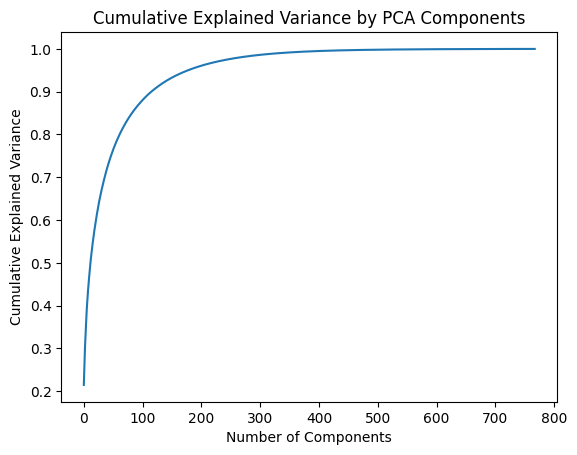

Number of components to explain 95% variance: 179


In [64]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(emb_size).fit(X_train_cls)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.show()

# Find the number of components for a certain explained variance level, e.g., 95%
n_components_95 = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1
print(f"Number of components to explain 95% variance: {n_components_95}")


## RandPCA

In [65]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as RandomizedPCA
randPCA_model = RandomizedPCA(emb_size).fit(X_train_cls)

In [66]:
# Estimate intrinsic dimensionality based on different thresholds

# Assuming model.explained_variance_ratio_ is the variance ratio array from PCA
cumulative_variance = np.cumsum(randPCA_model.explained_variance_ratio_)

# Thresholds
thresholds = [0.6, 0.8, 0.9, 0.95, 0.975]

# Finding the number of components for each threshold
n_components_for_threshold = {}
for threshold in thresholds:
    n_components = np.where(cumulative_variance >= threshold)[0][0] + 1  # Adding 1 because of 0-indexing
    n_components_for_threshold[threshold] = n_components

print(n_components_for_threshold)

# Write to file
with open(txt_file_path, 'w') as file:
    file.write('Randomized PCA intrinsic dimensionality estimates given threshold\n')
    file.write(str(n_components_for_threshold) + '\n')
print(f"File written at {txt_file_path}")

{0.6: 22, 0.8: 62, 0.9: 116, 0.95: 179, 0.975: 244}
File written at /content/drive/My Drive/projectx_pain/manifold_results/cola-DistilRoBERTaBase-cls/cola-DistilRoBERTaBase-cls-quant.txt


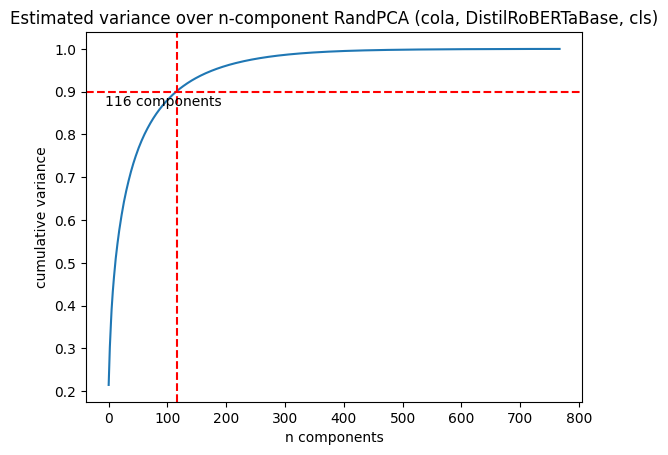

Plot saved at /content/drive/My Drive/projectx_pain/manifold_results/cola-DistilRoBERTaBase-cls/cola-DistilRoBERTaBase-cls-RandPCA.png


In [67]:
plt.plot(np.cumsum(randPCA_model.explained_variance_ratio_))
# Adding a horizontal line at 0.9 threshold
plt.axhline(y=0.9, color='r', linestyle='--')
# Adding a vertical line at the point where the cumulative variance reaches 0.9
plt.axvline(x=n_components_for_threshold[0.9], color='r', linestyle='--')
# Annotating the intersection point
plt.annotate(f'{n_components_for_threshold[0.9]} components', (n_components_for_threshold[0.9], 0.9), textcoords="offset points", xytext=(-10,-10), ha='center')

plt.xlabel('n components')
plt.ylabel('cumulative variance');
plt.title(f'Estimated variance over n-component RandPCA ({task}, {model_name}, {emb_type})')
# plt.show()


# Save plot

# Specify the path for the folder and the plot file
folder_path = f'/content/drive/My Drive/projectx_pain/manifold_results/{task}-{model_name}-{emb_type}'
plot_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-RandPCA.png')

# Check if the folder exists, create it if not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the plot
plt.savefig(plot_file_path)
plt.show()

print(f"Plot saved at {plot_file_path}")

In [68]:
# random bullshit; ignore

# from sklearn.decomposition import KernelPCA
# kernelPCA_model = KernelPCA(n_components=768, kernel='rbf').fit(X_train_cls)
# plt.plot(np.cumsum(kernelPCA_model.explained_variance_ratio_))
# plt.xlabel('n components')
# plt.ylabel('cumulative variance');
# plt.title(f'Estimated variance over n-component KernelPCA ({task}, {model_name}, {emb_type})')

In [69]:
# random bullshit; ignore

# X_train_cls_np = X_train_cls.numpy()

# length = len(X_train_cls_np)

# interwoven_array = np.zeros((length, 1536))
# for i in range(768):
#     interwoven_array[:, 2*i] = X_train_cls_np[:, i]
#     interwoven_array[:, 2*i + 1] = Y_train

# X_train_cls = torch.from_numpy(interwoven_array)

# print(X_train_cls.shape)

In [70]:
# random bullshit, ignore

# X_train_cls_np = np.zeros((6734, 768))
# for i in range(768):
#   X_train_cls_np[:, i]= interwoven_array[:, 2*i]

# print(X_train_cls_np.shape)
# print(X_train_cls_np[0])
# print(X_train_cls_np[-1])

## [ignore] TwoNN

In [71]:
# from sklearn.neighbors import NearestNeighbors
# import numpy as np

# def estimate_intrinsic_dimension(X, k=2):
#     # Compute nearest neighbors
#     nbrs = NearestNeighbors(n_neighbors=k).fit(X)
#     distances, indices = nbrs.kneighbors(X)

#     print(distances)
#     print('\n')
#     print(indices)

#     # Compute the ratio of distances
#     distance_ratios = distances[:, 1] / distances[:, 0]

#     # Use the TwoNN method to estimate intrinsic dimensionality
#     intrinsic_dim = -2 / (np.mean(np.log(distance_ratios)))
#     return intrinsic_dim

# X = X_train_cls  # Replace with your embeddings
# intrinsic_dimension = estimate_intrinsic_dimension(X)
# print(f"Estimated intrinsic dimensionality: {intrinsic_dimension}")

## [ignore] Minka's MLE

In [72]:
# from sklearn.neighbors import NearestNeighbors
# import numpy as np
# from sklearn.decomposition import KernelPCA

# def mle_intrinsic_dimension(X, k=2):
#     # Compute pairwise distances
#     nbrs = NearestNeighbors(n_neighbors=k).fit(X)
#     distances, _ = nbrs.kneighbors(X)

#     # Compute the log of distances
#     log_distances = np.log(distances[:, 1:])

#     # Estimate the intrinsic dimensionality
#     return -np.mean(log_distances) / np.log(k - 1)

# X = X_train_cls  # Replace with your embeddings
# intrinsic_dimension_mle = mle_intrinsic_dimension(X)
# print(f"Estimated intrinsic dimensionality (MLE): {intrinsic_dimension_mle}")


## Isomap
Isomap seeks a lower-dimensional embedding which maintains geodesic distances between all points

In [ ]:
from sklearn.manifold import Isomap
isomap_model = Isomap(n_components=n_isomap_components)
proj = isomap_model.fit_transform(X_train_cls)

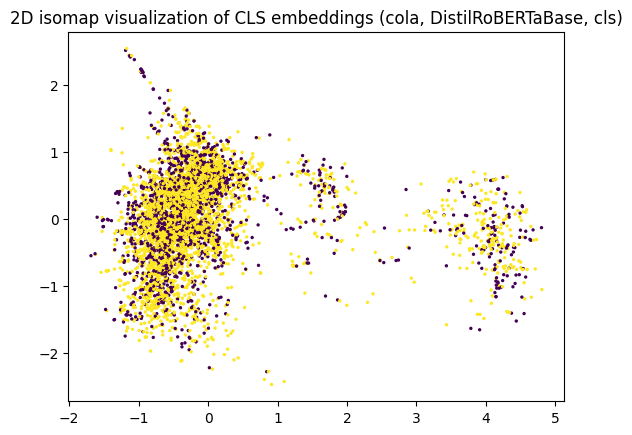

Plot saved at /content/drive/My Drive/projectx_pain/manifold_results/cola-DistilRoBERTaBase-cls/cola-DistilRoBERTaBase-cls-isomap.png


In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

point_size = 2

if n_isomap_components == 2:
  plt.scatter(proj[:, 0], proj[:, 1], s=point_size, c=Y_train, cmap='viridis')
  plt.title(f'2D isomap visualization of CLS embeddings ({task}, {model_name}, {emb_type})')
elif n_isomap_components == 3:
  fig = plt.figure(figsize=(12, 8))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s=point_size, c=Y_train, cmap='viridis')
  ax.set_title(f'3D isomap visualization of CLS embeddings ({task}, {model_name}, {emb_type})')


# Save plot

# Specify the path for the folder and the plot file
folder_path = f'/content/drive/My Drive/projectx_pain/manifold_results/{task}-{model_name}-{emb_type}'
plot_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-isomap.png')

# Check if the folder exists, create it if not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the plot
plt.savefig(plot_file_path)
plt.show()

print(f"Plot saved at {plot_file_path}")

## t-SNE
t-SNE converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. t-SNE usually doesn't handle very high

In [75]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Apply PCA
pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(X_train_cls) # if this errors out try adding a .numpy() to the end of X_train_cls

# Apply t-SNE
tsne = TSNE(n_components=n_tsne_components, random_state=0)
tsne_embeddings = tsne.fit_transform(reduced_embeddings)
tsne_embeddings_test = tsne.fit_transform(pca.fit_transform(X_test_cls)) # if this errors out try adding a .numpy() to the end of X_train_cls

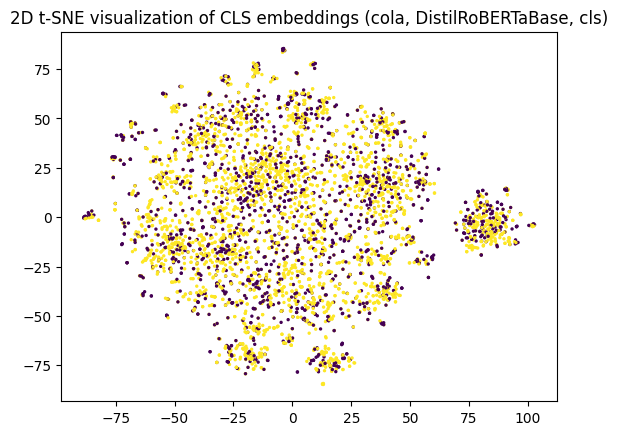

Plot saved at /content/drive/My Drive/projectx_pain/manifold_results/cola-DistilRoBERTaBase-cls/cola-DistilRoBERTaBase-cls-tSNE.png


In [76]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

point_size = 2

if n_tsne_components == 2:
  plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=point_size, c=Y_train, cmap='viridis')
  plt.title(f'2D t-SNE visualization of CLS embeddings ({task}, {model_name}, {emb_type})')
elif n_tsne_components == 3:
  fig = plt.figure(figsize=(12, 8))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], tsne_embeddings[:, 2], s=point_size, c=Y_train, cmap='viridis')
  ax.set_title(f'3D t-SNE visualization of CLS embeddings ({task}, {model_name}, {emb_type}')


# Save plot

# Specify the path for the folder and the plot file
folder_path = f'/content/drive/My Drive/projectx_pain/manifold_results/{task}-{model_name}-{emb_type}'
plot_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-tSNE.png')

# Check if the folder exists, create it if not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the plot
plt.savefig(plot_file_path)
plt.show()

print(f"Plot saved at {plot_file_path}")

# Evaluation

In [77]:
# this is just to stop the execution here because the code below is basically useless

assert False

AssertionError: ignored

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPRegressor

In [ ]:
# Assuming you have the t-SNE embeddings and labels already loaded
# tsne_embeddings: numpy array of shape (n_samples, L)
# labels: numpy array of shape (n_samples,)

# 1. Evaluate clusterness with Silhouette Score
silhouette_avg = silhouette_score(tsne_embeddings, Y_train)
print(f"Silhouette Score: {silhouette_avg}")

In [ ]:
# 2. Gaussian Mixture Model Clustering
# Choose the number of components based on domain knowledge, BIC, or AIC
n_components = 5  # for example
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(tsne_embeddings)
gmm_labels = gmm.predict(tsne_embeddings)
print(f"AIC: {gmm.aic(tsne_embeddings)}")
print(f"BIC: {gmm.bic(tsne_embeddings)}")

In [ ]:
# 3. Feed Forward Neural Network
# For simplicity, we'll use a regressor with one hidden layer of size 100
# You can adjust the architecture as needed
ffnn = MLPRegressor(hidden_layer_sizes=(630, 536, 397, 213, 100, 40,), random_state=42, max_iter=500)
ffnn.fit(X_train_cls, Y_train)

# To evaluate the FFNN, you might want to use mean squared error or similar metrics
# But ensure you have a train-test split or cross-validation for a proper evaluation

In [ ]:
from sklearn.metrics import mean_squared_error

# Predict on the test data
Y_pred = ffnn.predict(X_test_cls)

# Evaluate performance
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse}")

In [ ]:
print(Y_pred.shape)
print(tsne_embeddings_test.shape)
print(np.sum(Y_test == Y_pred))
print(Y_train)
print(Y_pred)

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Assuming 'tsne_embeddings' is your t-SNE 2D embeddings
# and 'true_labels' is the continuous labels from zero to five for the embeddings

# Create a NearestNeighbors model to find k-nearest neighbors
knn = NearestNeighbors(n_neighbors=10)  # Use an appropriate value for k
knn.fit(tsne_embeddings)

# Find the k-nearest neighbors for each point in the embeddings
distances, indices = knn.kneighbors(tsne_embeddings)

# Compute the local homogeneity score for each point
homogeneity_scores = []
for idx, point_indices in enumerate(indices):
    # Calculate the average label of the neighbors
    neighbor_labels = [Y_train[i] for i in point_indices[1:]]
    local_avg_label = np.mean(neighbor_labels[1:])  # Exclude the point itself
    # Compare the average to the point's true label
    homogeneity_score = abs(Y_train[idx] - local_avg_label)
    homogeneity_scores.append(homogeneity_score)

# Convert to a NumPy array for convenience
homogeneity_scores = np.array(homogeneity_scores)

# Compute the overall average homogeneity score for the dataset
average_homogeneity = np.mean(homogeneity_scores)
print(f'Average local homogeneity score: {average_homogeneity}')

# for distilroberta cls on stsb



---



In [ ]:
param_grid = {
    'num_epochs': [100],
    'batch_size': [32, 128, 512],
    'learning_rate': [1e-2, 1e-3, 1e-4, 1e-5],
    'category': ['C'],
    'norm': [False],
    'size': [768],
    'num_layers': [1, 3, 5, 10],
    'weight_decay': [1e-2, 1e-3, 1e-4, 1e-5],
    'patience': [3],
    'min_delta': [0],
    'device': [device]
}

# Create a list of all combinations of hyperparameters
all_params = [dict(zip(param_grid.keys(), v))
              for v in itertools.product(*param_grid.values())]

best_params = None
highest_val_accuracy = 0

# Iterate over all combinations of hyperparameters
for params in all_params:
    print("Training with parameters:", params)
    # Initialize the model with current set of hyperparameters
    feed_forward = FeedForward(**params)

    _, _, val_accuracy = feed_forward.fit(X_train, Y_train, X_val, Y_val)
    print("Validation accuracy:", val_accuracy)

    # Save the parameters if they provide a better accuracy
    if val_accuracy > highest_val_accuracy:
        highest_val_accuracy = val_accuracy
        best_params = params

# Print the best parameters
print("Best Parameters:", best_params)
print("Highest Validation Accuracy:", highest_val_accuracy)

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0, :]

## Write results to file

In [ ]:
# Specify the path for the folder and the file
folder_path = f'/content/drive/My Drive/projectx_pain/manifold_results/{task}-{model_name}-{emb_type}'
file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-quant.txt')

# Check if the folder exists, create it if not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Write text to the file
text_to_write = "This is the text that I want to write to the file."
with open(file_path, 'w') as file:
    file.write(text_to_write)

print(f"File written at {file_path}")

#Ignore

In [ ]:


# # Specify the path to your embeddings file in Google Drive
# # Update the path below according to where your file is stored in Google Drive
# file_path = f'/content/drive/My Drive/projectx_pain/embeddings/cls/stsb/X_train_1_cls.npy'
# X_train_1_cls = np.load(file_path)
# file_path = f'/content/drive/My Drive/projectx_pain/embeddings/cls/stsb/X_train_2_cls.npy'
# X_train_2_cls = np.load(file_path)
# file_path = f'/content/drive/My Drive/projectx_pain/embeddings/cls/stsb/X_test_1_cls.npy'
# X_test_1_cls = np.load(file_path)
# file_path = f'/content/drive/My Drive/projectx_pain/embeddings/cls/stsb/X_test_2_cls.npy'
# X_test_2_cls = np.load(file_path)
# file_path = f'/content/drive/My Drive/projectx_pain/embeddings/cls/stsb/X_val_1_cls.npy'
# X_val_1_cls = np.load(file_path)
# file_path = f'/content/drive/My Drive/projectx_pain/embeddings/cls/stsb/X_val_2_cls.npy'
# X_val_2_cls = np.load(file_path)

# # Check the shape of the loaded embeddings
# print("X_train_1_cls shape:", X_train_1_cls.shape)

# # If your embeddings are in a different format, e.g., a CSV file, use the appropriate method to load them
# # For example, for a CSV file:
# # embeddings = pd.read_csv(file_path)

# # set to u-v embedding
# X_train_DistilRoBERTaBase = np.hstack((X_train_1_cls, X_train_2_cls))
# X_test_DistilRoBERTaBase = np.hstack((X_test_1_cls, X_test_2_cls))
# X_val_DistilRoBERTaBase = np.hstack((X_val_1_cls, X_val_2_cls))

# # Check the shape of the loaded embeddings
# print("X_train_cls shape:", X_train_DistilRoBERTaBase.shape)
# print("X_test_cls shape:", X_test_DistilRoBERTaBase.shape)
# print("X_val_cls shape:", X_val_DistilRoBERTaBase.shape)


# # # Save to the mounted Google Drive
# # path = "/content/drive/MyDrive/projectx_pain/cls/stsb"
# # np.save(path + "X_train_DistilRoBERTaBase", X_train_DistilRoBERTaBase)
# # np.save(path + "X_test_DistilRoBERTaBase", X_test_DistilRoBERTaBaseval_1_cls)
# # np.save(path + "X_val_DistilRoBERTaBase", X_val_DistilRoBERTaBase)

# path = "/content/drive/MyDrive/projectx_pain/embeddings/cls/stsb/"
# os.makedirs(path, exist_ok=True)  # This creates the directory if it doesn't exist

# np.save(path + "X_train_DistilRoBERTaBase", X_train_DistilRoBERTaBase)
# np.save(path + "X_test_DistilRoBERTaBase", X_test_DistilRoBERTaBase)
# np.save(path + "X_val_DistilRoBERTaBase", X_val_DistilRoBERTaBase)

In [ ]:
# if not cached:
#   # Save embeddings

#   np.save(f'dr_{task}_X_train_1_cls.npy', X_train_1_cls)  # Saves the file in the current directory
#   np.save(f'dr_{task}_X_val_1_cls.npy', X_val_1_cls)
#   np.save(f'dr_{task}_X_test_1_cls.npy', X_test_1_cls)
#   np.save(f'dr_{task}_X_train_2_cls.npy', X_train_2_cls)
#   np.save(f'dr_{task}_X_val_2_cls.npy', X_val_2_cls)
#   np.save(f'dr_{task}_X_test_2_cls.npy', X_test_2_cls)

## [ignore] get u*v embedding; skip if not generating cached embeddings

In [ ]:
# ### 2s

# # u*v
# X_train_cls = X_train_1_cls * X_train_2_cls

In [ ]:
# this is just from when i saved the two sentence embeddings for two-sentence tasks in separate files; ignore

# if cached:
#   # Specify the path to your embeddings file in Google Drive
#   # Update the path below according to where your file is stored in Google Drive
#   file_path = f'/content/drive/My Drive/projectx_pain/embeddings/{emb_type}/{task}/X_train_1_cls.npy'

#   # Load the embeddings
#   # This example assumes the embeddings are saved in a NumPy .npy file
#   X_train_1_cls = np.load(file_path)

#   file_path = f'/content/drive/My Drive/projectx_pain/{task}_embeddings/X_train_2_cls.npy'
#   X_train_2_cls = np.load(file_path)

#   file_path = f'/content/drive/My Drive/projectx_pain/{task}_embeddings/X_test_1_cls.npy'
#   X_test_1_cls = np.load(file_path)

#   file_path = f'/content/drive/My Drive/projectx_pain/{task}_embeddings/X_test_2_cls.npy'
#   X_test_2_cls = np.load(file_path)

#   # If your embeddings are in a different format, e.g., a CSV file, use the appropriate method to load them
#   # For example, for a CSV file:
#   # embeddings = pd.read_csv(file_path)

#   # Check the shape of the loaded embeddings
#   print("X_train_1 shape:", X_train_1_cls.shape)